In [11]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Descargar datos históricos de ETH
ticker='ETH-USD'
eth_data =yf.Ticker(ticker)
eth_data = eth_data.history(start="2022-01-01", end="2025-01-26")

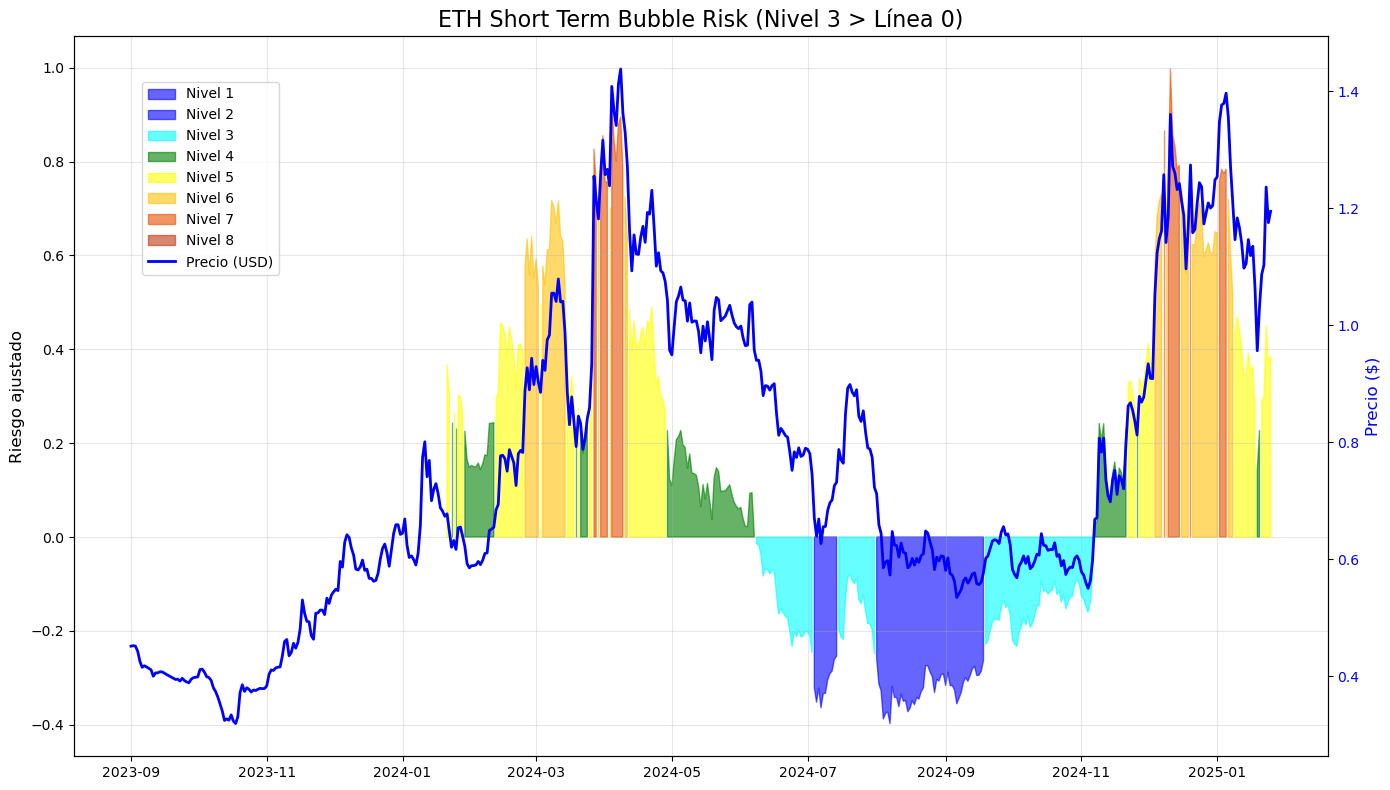

In [12]:
# Descargar datos históricos de ETH
ticker='MNT27075-USD'
eth_data =yf.Ticker(ticker)
eth_data = eth_data.history(start="2023-09-01", end="2025-01-26")

# Calcular medias móviles
eth_data['SMA_20W'] = eth_data['Close'].rolling(window=140).mean()  # Media móvil de 20 semanas (~140 días)

# Calcular relación Precio/SMA
eth_data['Price_to_SMA'] = eth_data['Close'] / eth_data['SMA_20W']

# Transformar valores menores a 1 para que sean negativos
def adjust_scale(value):
    return value - 1 if value < 1 else value - 1

eth_data['Adjusted_Price_to_SMA'] = eth_data['Price_to_SMA'].apply(adjust_scale)

# Definir categorías de riesgo
conditions = [
    (eth_data['Price_to_SMA'] < 0.5),
    (eth_data['Price_to_SMA'] >= 0.5) & (eth_data['Price_to_SMA'] < 0.75),
    (eth_data['Price_to_SMA'] >= 0.75) & (eth_data['Price_to_SMA'] < 1),
    (eth_data['Price_to_SMA'] >= 1) & (eth_data['Price_to_SMA'] < 1.25),
    (eth_data['Price_to_SMA'] >= 1.25) & (eth_data['Price_to_SMA'] < 1.5),
    (eth_data['Price_to_SMA'] >= 1.5) & (eth_data['Price_to_SMA'] < 1.75),
    (eth_data['Price_to_SMA'] >= 1.75) & (eth_data['Price_to_SMA'] < 2),
    (eth_data['Price_to_SMA'] >= 2)
]

colors = ['blue', 'blue', 'cyan','green', 'yellow', '#ffc107', '#e65100', '#bf360c']

# Crear una columna categórica para riesgo
eth_data['Risk_Level'] = np.select(conditions, range(len(colors)), default=np.nan)


# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(14, 8))

# Gráfico de riesgo como áreas coloreadas (en el eje principal)
for i, color in enumerate(colors):
    mask = eth_data['Risk_Level'] == i
    ax1.fill_between(eth_data.index, 0, eth_data['Adjusted_Price_to_SMA'].where(mask), 
                     color=color, alpha=0.6, label=f'Nivel {i + 1}')

# Configurar el eje principal (riesgo)
ax1.set_ylabel('Riesgo ajustado', fontsize=12)
ax1.tick_params(axis='y')
ax1.set_title('ETH Short Term Bubble Risk (Nivel 3 > Línea 0)', fontsize=16)
ax1.grid(alpha=0.3)

# Crear un segundo eje `y` para el precio
ax2 = ax1.twinx()
ax2.plot(eth_data.index, eth_data['Close'], label='Precio (USD)', color='blue', linewidth=2, linestyle='-')
ax2.set_ylabel('Precio ($)', fontsize=12, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Agregar la leyenda combinada
fig.legend(loc='upper left', fontsize=10, bbox_to_anchor=(0.1, 0.9))

# Ajustar diseño
plt.tight_layout()
plt.show()

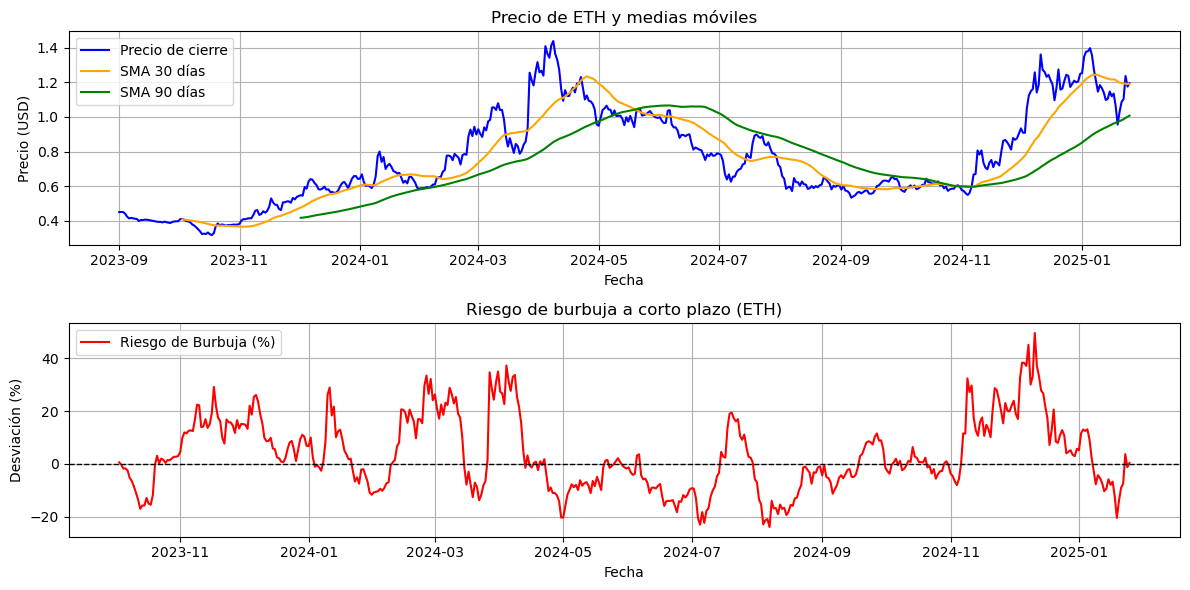

In [13]:

# Calcular medias móviles
eth_data['SMA_30'] = eth_data['Close'].rolling(window=30).mean()  # Media móvil a corto plazo
eth_data['SMA_90'] = eth_data['Close'].rolling(window=90).mean()  # Media móvil a largo plazo

# Calcular desviación del precio respecto a las medias móviles
eth_data['Bubble_Risk'] = ((eth_data['Close'] - eth_data['SMA_30']) / eth_data['SMA_30']) * 100

# Crear la figura y los ejes
plt.figure(figsize=(12, 6))

# Gráfico del precio de cierre y medias móviles
plt.subplot(2, 1, 1)
plt.plot(eth_data.index, eth_data['Close'], label='Precio de cierre', color='blue')
plt.plot(eth_data.index, eth_data['SMA_30'], label='SMA 30 días', color='orange')
plt.plot(eth_data.index, eth_data['SMA_90'], label='SMA 90 días', color='green')
plt.title('Precio de ETH y medias móviles')
plt.xlabel('Fecha')
plt.ylabel('Precio (USD)')
plt.legend()
plt.grid()

# Gráfico de riesgo de burbuja
plt.subplot(2, 1, 2)
plt.plot(eth_data.index, eth_data['Bubble_Risk'], label='Riesgo de Burbuja (%)', color='red')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Riesgo de burbuja a corto plazo (ETH)')
plt.xlabel('Fecha')
plt.ylabel('Desviación (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

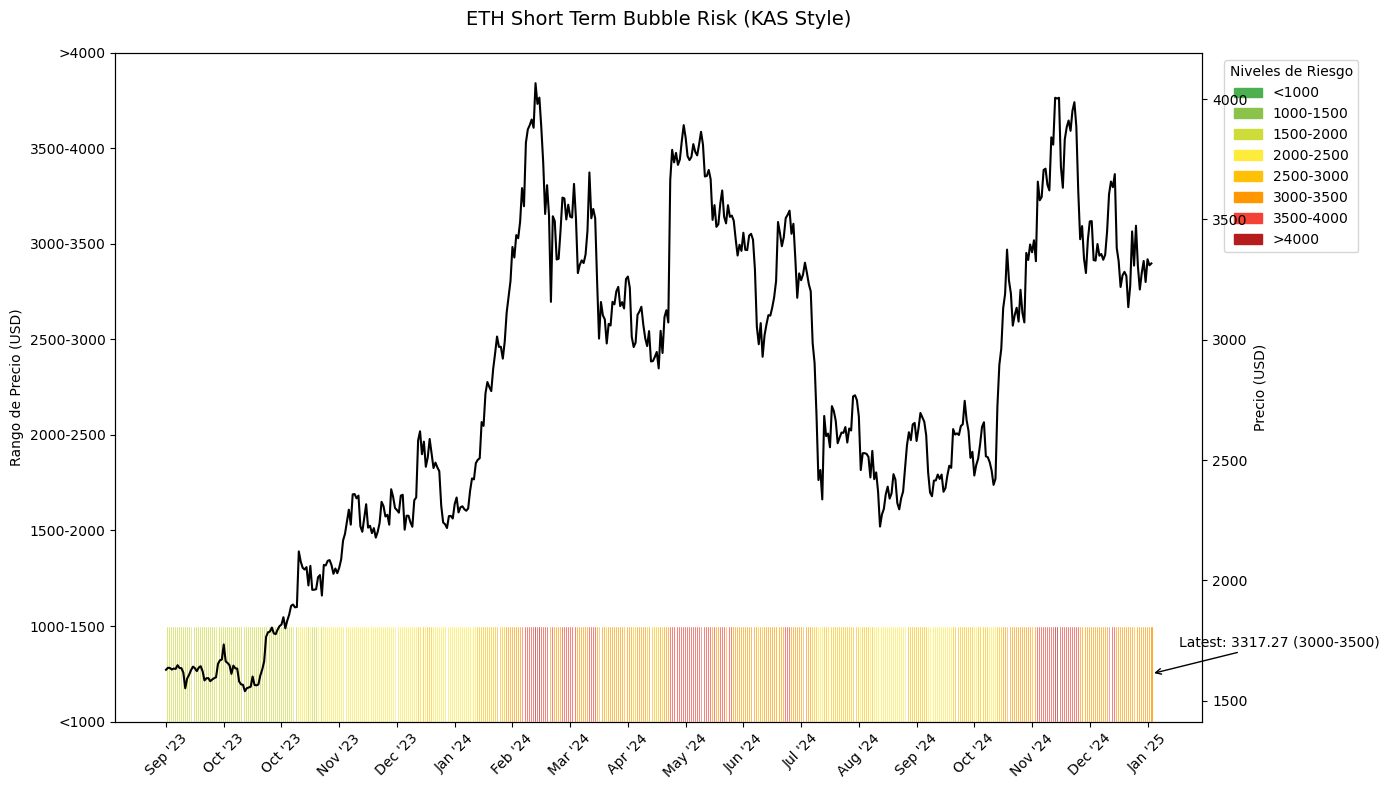

In [15]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ----------------------------------------------
# 1. Correcciones en la obtención de datos
# ----------------------------------------------
ticker = "ETH-USD"  # Ticker corregido
eth_data = yf.Ticker(ticker)

# Fechas ajustadas (Yahoo Finance no soporta futuros)
eth_data = eth_data.history(start="2023-09-01", end=pd.Timestamp.today().strftime("%Y-%m-%d")) 

# ----------------------------------------------
# 2. Cálculo de métricas (adaptado al gráfico KAS)
# ----------------------------------------------
# Definir categorías de precio (no Price/SMA)
bins = [0, 1000, 1500, 2000, 2500, 3000, 3500, 4000, np.inf]
labels = [
    "<1000", "1000-1500", "1500-2000", "2000-2500",
    "2500-3000", "3000-3500", "3500-4000", ">4000"
]

# Clasificar precios en categorías (como el KAS original)
eth_data["Price_Category"] = pd.cut(eth_data["Close"], bins=bins, labels=labels, right=False)

# ----------------------------------------------
# 3. Gráfico tipo "mapa de calor" por categorías
# ----------------------------------------------
fig, ax = plt.subplots(figsize=(14, 8))

# Colores alineados con el riesgo (rojo = alto riesgo)
colors = ['#4CAF50', '#8BC34A', '#CDDC39', '#FFEB3B', '#FFC107', '#FF9800', '#F44336', '#B71C1C']

# Crear barras verticales coloreadas por categoría
for date, category in zip(eth_data.index, eth_data["Price_Category"]):
    color = colors[labels.index(category)] if pd.notnull(category) else "gray"
    ax.bar(date, height=1, width=1.5, color=color, edgecolor="white")  # Ancho ajustado

# ----------------------------------------------
# 4. Elementos adicionales del gráfico KAS
# ----------------------------------------------
# Añadir línea de precio superpuesta
ax2 = ax.twinx()
ax2.plot(eth_data.index, eth_data["Close"], color="black", linewidth=1.5, label="Precio ETH")
ax2.set_ylabel("Precio (USD)", color="black")

# Último valor anotado (como en KAS)
last_price = eth_data["Close"].iloc[-1]
last_category = eth_data["Price_Category"].iloc[-1]
ax.annotate(
    f"Latest: {last_price:.2f} ({last_category})",
    xy=(eth_data.index[-1], 0.5),
    xytext=(20, 20),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", color="black")
)

# ----------------------------------------------
# 5. Personalización de ejes y leyenda
# ----------------------------------------------
# Eje Y (categorías de precio)
ax.set_yticks(range(len(labels)), labels=labels)
ax.set_ylabel("Rango de Precio (USD)")

# Eje X (formato de fechas)
ax.set_xticks(eth_data.index[::30])  # Cada ~1 mes
ax.set_xticklabels([date.strftime("%b '%y") for date in eth_data.index[::30]], rotation=45)

# Leyenda de categorías
handles = [plt.Rectangle((0,0), 1, 1, color=colors[i]) for i in range(len(labels))]
ax.legend(handles, labels, title="Niveles de Riesgo", bbox_to_anchor=(1.15, 1))

ax.set_title("ETH Short Term Bubble Risk (KAS Style)", fontsize=14, pad=20)
plt.tight_layout()
plt.show()